In [ ]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import networkx as nx

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

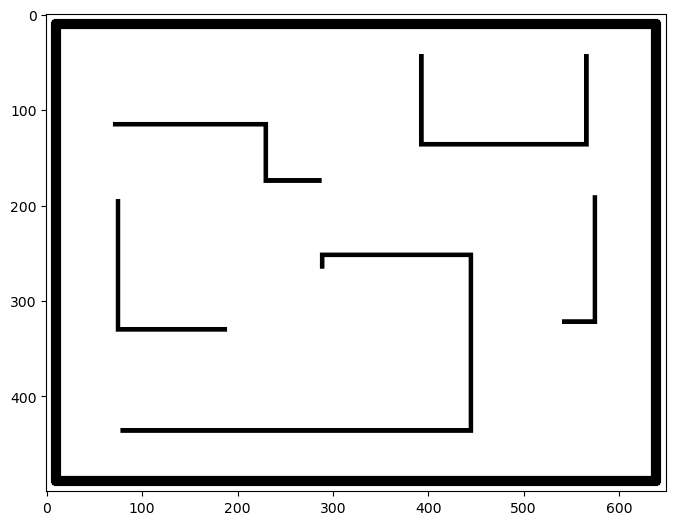

In [56]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = mpimg.imread('mapas/paredes2.png')

img = img[:, :, 0]

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

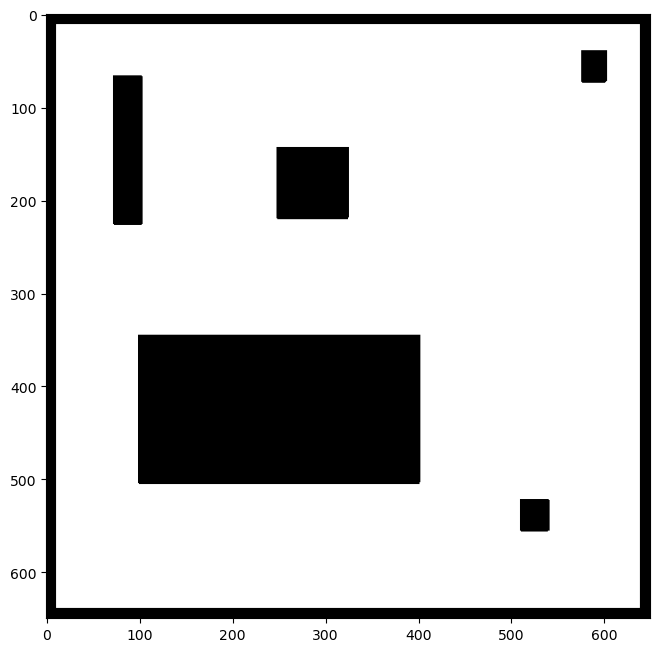

In [61]:
# Rode este para testar com o outro mapa/cena de Minimapa2
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = mpimg.imread('mapas/minimapa2.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

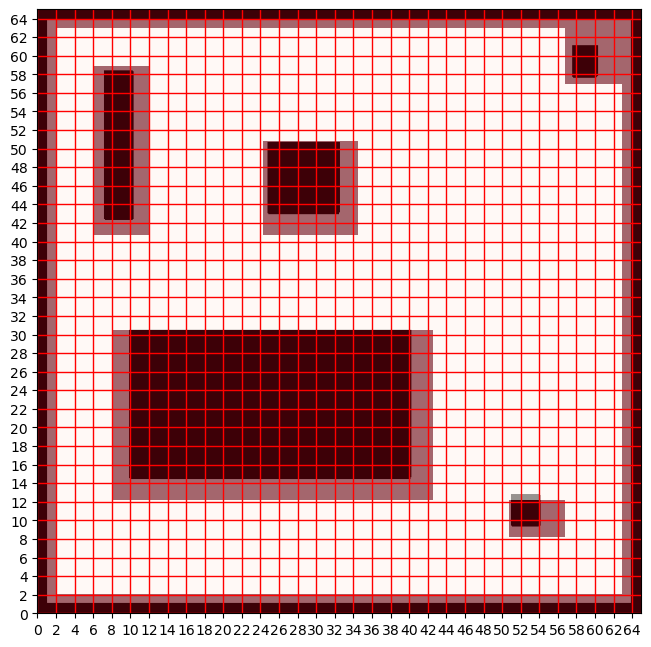

In [62]:
# Dimensões do mapa informado em metros (X, Y)
# map_dims = np.array([70, 70]) # Cave 
map_dims = np.array([65, 65]) # Paredes
#map_dims = np.array([22, 43])  # Maze
# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

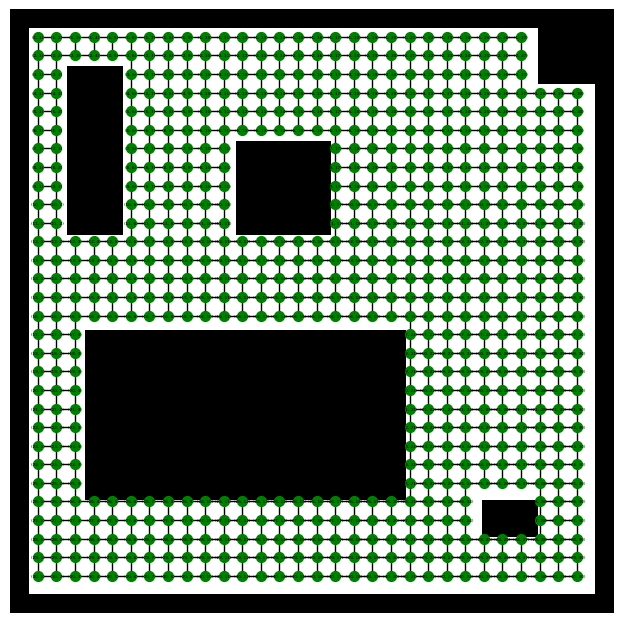

In [63]:
# Criando o Grafo para o nosso Grid

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims_paredes[1], 0, map_dims_paredes[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims_paredes[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims_paredes[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims_paredes[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

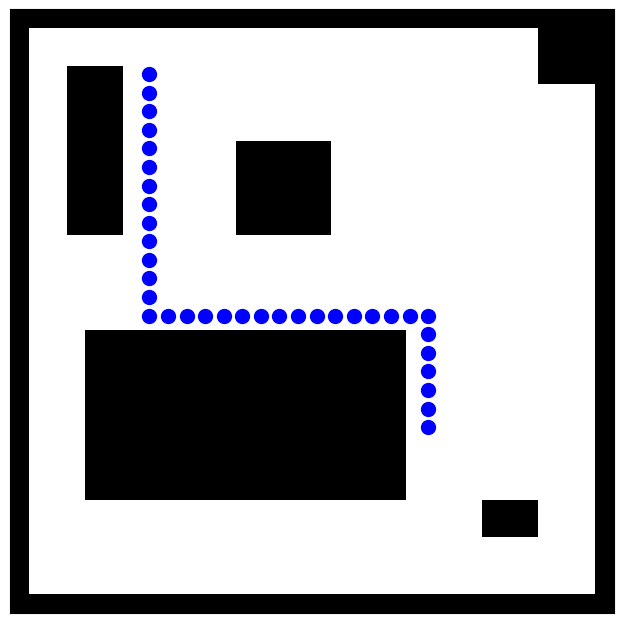

In [65]:
# Finalmente podemos determinar o menor caminho entre duas células
# ATENÇÃO para o Sistema de Coordenadas -- relação Índice do grid e Posição no mundo

# Paredes
# start_node = (25, 18)
# end_node = (5, 8)

#Minimapa
start_node = (22, 22)
end_node = (3, 7)


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

In [66]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    robotname = 'robotino'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)     
                 
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
               
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    gain = np.array([[0.3, 0, 0], [0, 0.3, 0], [0, 0, 0.3]])
    
    lastNode = (path[0][0], path[0][1])
    for y, x in path:
        currNode = (y, x)
        direction = tuple(map(lambda i, j: i - j, currNode, lastNode))
        dx = direction[1]
        dy = direction[0]

        lastNode = (y, x)

        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
        returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        
        returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'ReferenceFrame', sim.simx_opmode_oneshot_wait)     
        returnCode, goalFramePos = sim.simxGetObjectPosition(clientID, goalFrame, -1, sim.simx_opmode_oneshot_wait)
        returnCode, goalFrameOri = sim.simxGetObjectPosition(clientID, goalFrame, -1, sim.simx_opmode_oneshot_wait)
        
        q = np.array([pos[0], pos[1], ori[2]])
        qgoal = np.array([pos[0]+dx, pos[1]-dy, ori[2]])

        while True:

            returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
            returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            q = np.array([pos[0], pos[1], ori[2]])
            
            error = qgoal - q

            # Margem aceitável de distância
            if (np.linalg.norm(error[:2]) < 0.05):
                break

            # Controller
            qdot = gain @ error

            # Cinemática Inversa
            # w1, w2, w3
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot
            
            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)          
               
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

Program started
Connected to remote API server
Program ended
